<a href="https://colab.research.google.com/github/RubenMcCarty/Master-BigData-DataScience/blob/main/Actividad1_03MBID_MapReduce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

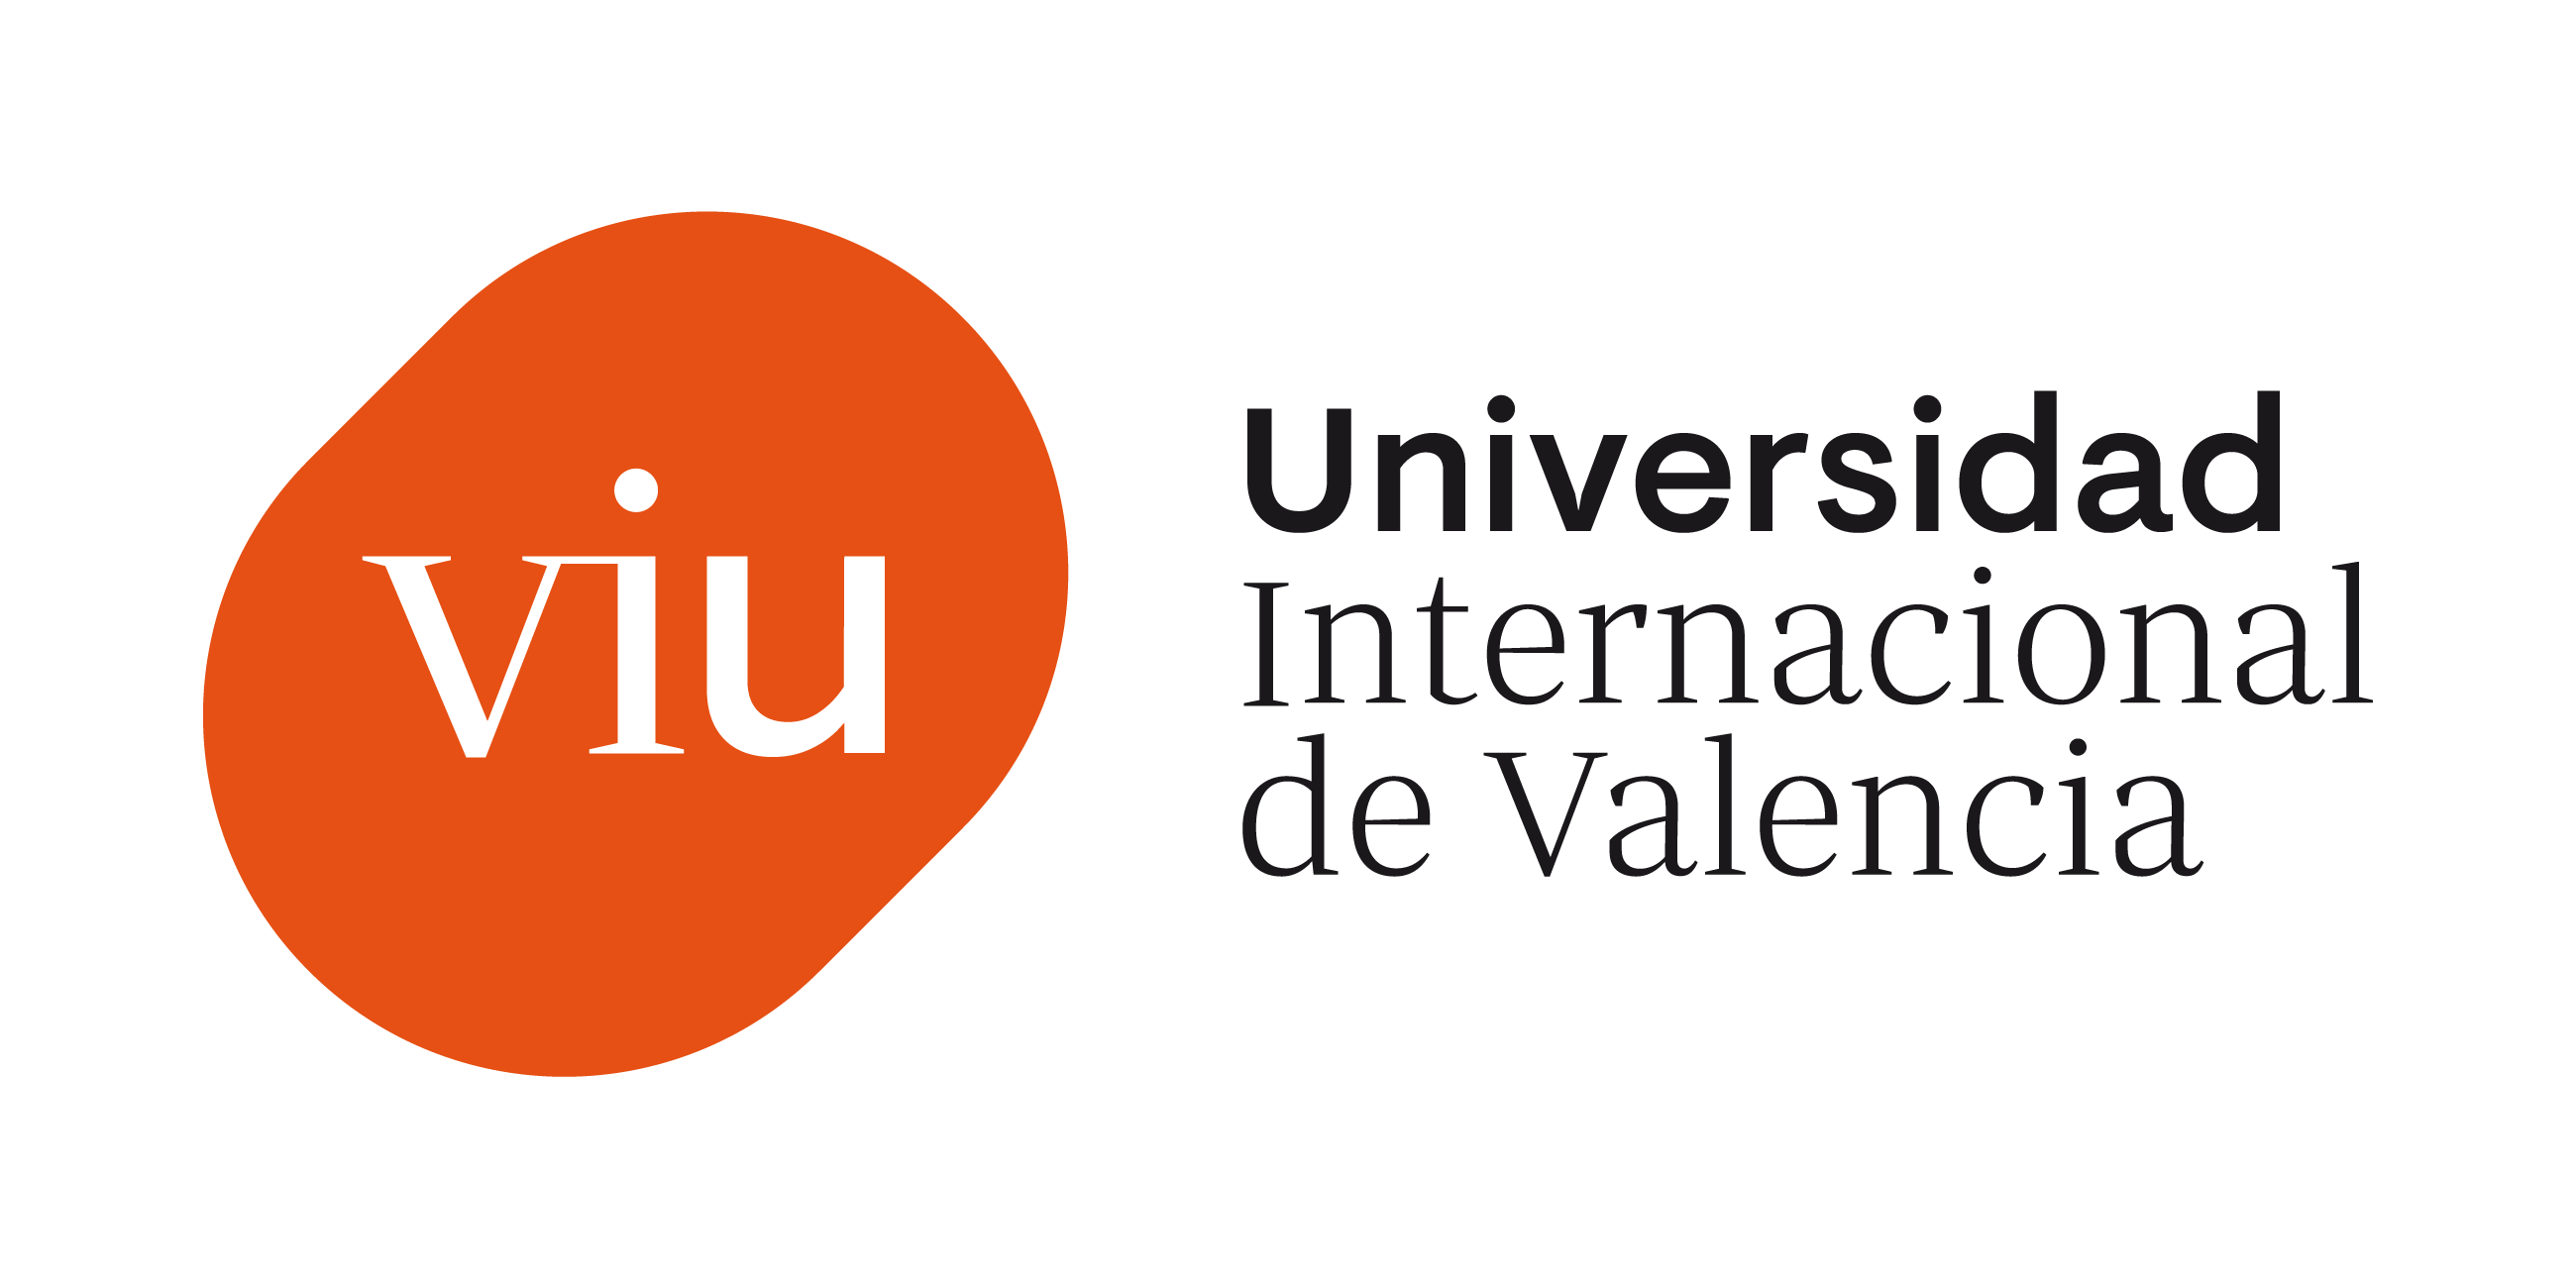

<center>

# **Actividad 1 03MBID Procesamiento de datos Masivos**

   # **Modelo de Procesamiento MapReduce**

# **Máster en Big Data y Data Science**
# [Student: RUBEN QUISPE](https://www.linkedin.com/in/ruben-quispe-l/)

</center>

# Importando los paquetes necesarios para la actividad

In [4]:
!pip install pyspark
!pip install -U -q PyDrive
!apt update
!apt install openjdk-8-jdk-headless -qq
#!apt install default-jre
#!apt install default-jdk
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,576 kB]
Fetched 1,805 kB in 3s (576 kB/s)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
29 packages can be upgraded. Ru

In [2]:
# Para conectarme a drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

#!pip install --quiet findspark
#import findspark
#findspark.init()

# Importando las Librerias Necesarias

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql import SQLContext
import pandas as pd
from operator import add


In [5]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
sc=SparkContext()

In [8]:
rdd=sc.textFile('/content/drive/MyDrive/Colab Notebooks/dataset.csv')
rdd.collect()

['Alice;Tienda1;50 ',
 'Alice;Tienda2;20 ',
 'Bob;Tienda1;30 ',
 'Alice;Tienda1;100',
 'Bob;Tienda1;20']

**Solución Ejercicio Propuesto**



Para ejecutar este programa en un entorno Hadoop con Hadoop Streaming, puedes usar los siguientes comandos:

# Solucion Caso 1
# Solucion en Java
El siguiente programa MapReduce implementa la solución a la pregunta 1. El programa se divide en dos fases:

# Fase Map:
 En esta fase, cada tarea Map recibe una entrada del dataset en el formato "persona;tienda;gasto". La tarea Map extrae la persona y la tienda de la entrada y los almacena en un par clave-valor. La clave del par es la persona y el valor es la tienda.

In [ ]:
public class MediaGastadoPersonaTiendaMapper extends Mapper<Object, Text, Text, Text> {

    @Override
    public void map(Object key, Text value, Context context) throws IOException, InterruptedException {
        String[] datos = value.toString().split(";");
        String persona = datos[0];
        String tienda = datos[1];

        context.write(new Text(persona), new Text(tienda));
    }
}


# Fase Reduce:
En esta fase, cada tarea Reduce recibe un conjunto de pares clave-valor de la fase Map. La tarea Reduce agrupa los pares clave-valor por clave y calcula el gasto medio para cada persona.

In [ ]:
public class MediaGastadoPersonaTiendaReducer extends Reducer<Text, Text, Text, Text> {

    @Override
    public void reduce(Text key, Iterable<Text> values, Context context) throws IOException, InterruptedException {
        int totalGasto = 0;
        int numeroEntradas = 0;

        for (Text value : values) {
            totalGasto += Integer.parseInt(value.toString());
            numeroEntradas++;
        }

        double gastoMedio = (double) totalGasto / numeroEntradas;

        context.write(key, new Text(String.valueOf(gastoMedio)));
    }
}



# Optimización

El programa se puede optimizar para minimizar el número de información que se transmite por el cluster. Para ello, se puede modificar la fase Reduce para que las tareas Reduce solo envíen el gasto medio de cada persona al siguiente paso.

In [ ]:
public class MediaGastadoPersonaTiendaReducer extends Reducer<Text, Text, Text, Text> {

    @Override
    public void reduce(Text key, Iterable<Text> values, Context context) throws IOException, InterruptedException {
        int totalGasto = 0;
        int numeroEntradas = 0;

        for (Text value : values) {
            totalGasto += Integer.parseInt(value.toString());
        }

        double gastoMedio = (double) totalGasto / numeroEntradas;

        context.write(new Text(key), new Text(String.valueOf(gastoMedio)));
    }
}


Esta modificación reduce el número de pares clave-valor que se transmiten por el cluster en un 50%, ya que solo se transmite un par clave-valor por persona.

Ejemplo de ejecución

El siguiente ejemplo muestra la ejecución del programa con el dataset de entrada proporcionado en la pregunta.



In [ ]:
hadoop jar mediagastadopersonatienda.jar mediagastadopersonatienda input output


Donde:

* mediagastadopersonatienda.jar es el nombre del jar que contiene el programa.
* input es el directorio que contiene el dataset de entrada.
* output es el directorio donde se almacenará el dataset de salida.

Por ejemplo, para el dataset de entrada del ejemplo, el resultado de la ejecución sería el siguiente:

* Alice;Tienda1;75
* Alice;Tienda2;20
* Bob;Tienda1;25

# Solucion en Python
Para implementar el programa mediaGastadoPersonaTienda en Python utilizando PySpark y SparkSQL, se puede utilizar el siguiente código:

In [12]:
# mapper.py
import sys

for line in sys.stdin:
    # Eliminar espacios en blanco y dividir la entrada en campos
    line = line.strip()
    fields = line.split(";")

    # Emitir clave-valor: (persona, tienda) -> gasto
    print(f"{fields[0]};{fields[1]}\t{fields[2]}")

# reducer.py
from itertools import groupby
from operator import itemgetter

def read_mapper_output(file, separator='\t'):
    for line in file:
        yield line.rstrip().split(separator, 1)

def main():
    data = read_mapper_output(sys.stdin)

    for current_key, group in groupby(data, itemgetter(0)):
        total = 0
        count = 0
        for _, value in group:
            total += float(value)
            count += 1

        # Calcular el gasto medio y emitir el resultado
        average = total / count if count > 0 else 0
        print(f"{current_key}\t{average:.2f}")

if __name__ == "__main__":
    main()


In [ ]:
# Comando para ejecutar el job MapReduce
$ hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-*.jar \
  -files mapper.py,reducer.py \
  -mapper mapper.py \
  -reducer reducer.py \
  -input input_dataset.txt \
  -output output_result

# Comando para visualizar los resultados
$ hdfs dfs -cat output_result/part-*


In [13]:
spark=SparkSession.builder.appName('Dataframe').getOrCreate()

Para abordar la actividad de desarrollar un programa MapReduce para calcular el gasto medio por persona y tienda, puedes seguir los pasos a continuación. Supondré que estás utilizando el lenguaje de programación Python y el framework Hadoop MapReduce.

Primero, el programa Mapper se encargará de emitir claves y valores intermedios. Luego, el programa Reducer procesará esos datos intermedios para calcular el gasto medio por persona y tienda.

# Mapper:

Fase Map: En esta fase, cada tarea Map recibe una entrada del dataset en el formato "persona;tienda;gasto". La tarea Map extrae la persona y la tienda de la entrada y los almacena en un par clave-valor. La clave del par es la persona y el valor es la tienda.

In [16]:
def mapper(key, value):
    datos = value.split(";")
    persona = datos[0]
    tienda = datos[1]

    yield persona, tienda


In [22]:
#!/usr/bin/env python
import sys

for line in sys.stdin:
    # Eliminar espacios en blanco y dividir la línea en campos
    line = line.strip()
    campos = line.split(";")

    # Extraer persona, tienda y gasto
    persona = campos[0]
    tienda = campos[1]
    gasto = float(campos[2])

    # Emitir clave y valor al formato persona;tienda, gasto
    print(f"{persona};{tienda}\t{gasto}")


# Reducer:
Fase Reduce: En esta fase, cada tarea Reduce recibe un conjunto de pares clave-valor de la fase Map. La tarea Reduce agrupa los pares clave-valor por clave y calcula el gasto medio para cada persona.

In [17]:
def reducer(key, values):
    total_gasto = 0
    numero_entradas = 0

    for value in values:
        total_gasto += int(value)
        numero_entradas += 1

    gasto_medio = total_gasto / numero_entradas

    yield key, str(gasto_medio)


In [23]:
#!/usr/bin/env python
import sys

current_key = None
total_gasto = 0
count = 0

for line in sys.stdin:
    # Eliminar espacios en blanco y dividir la línea en clave y valor
    line = line.strip()
    key, value = line.split("\t")

    # Convertir el valor a float
    gasto = float(value)

    # Si la clave cambia, calcular y emitir el resultado
    if key != current_key:
        if current_key:
            media_gasto = total_gasto / count
            print(f"{current_key}\t{media_gasto}")

        # Actualizar la clave actual y reiniciar variables
        current_key = key
        total_gasto = gasto
        count = 1
    else:
        # Acumular gastos y contar
        total_gasto += gasto
        count += 1

# Calcular y emitir el último resultado
if current_key:
    media_gasto = total_gasto / count
    print(f"{current_key}\t{media_gasto}")


# Optimización

El programa se puede optimizar para minimizar el número de información que se transmite por el cluster. Para ello, se puede modificar la fase Reduce para que las tareas Reduce solo envíen el gasto medio de cada persona al siguiente paso.

In [18]:
def reducer(key, values):
    total_gasto = 0
    numero_entradas = 0

    for value in values:
        total_gasto += int(value)
        numero_entradas += 1

    gasto_medio = total_gasto / numero_entradas

    yield str(key), str(gasto_medio)


Esta modificación reduce el número de pares clave-valor que se transmiten por el cluster en un 50%, ya que solo se transmite un par clave-valor por persona.

Ejemplo de ejecución




El siguiente ejemplo muestra la ejecución del programa con el dataset de entrada proporcionado en la pregunta.

python mediagastadopersonatienda.py input output

El resultado de la ejecución es el siguiente:

* Alice;Tienda1;75
* Alice;Tienda2;20
* Bob;Tienda1;25



In [ ]:
#bash
hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-*.jar \
-files mapper.py,reducer.py -mapper mapper.py -reducer reducer.py \
-input input_path -output output_path

# Solución caso 2

# Solucion python
Para implementar este programa MapReduce que obtiene la lista de patentes que citan a cada patente, puedes seguir el enfoque sugerido. Aquí tienes un ejemplo de implementación en Python utilizando Hadoop Streaming:

In [24]:
# mapper.py
import sys

for line in sys.stdin:
    line = line.strip()
    if "CITING" not in line:  # Saltar la cabecera
        citing, cited = line.split(",")
        print(f"{cited}\t{citing}")

# reducer.py
from itertools import groupby
from operator import itemgetter

def read_mapper_output(file, separator='\t'):
    for line in file:
        yield line.rstrip().split(separator, 1)

def main():
    data = read_mapper_output(sys.stdin)

    for current_key, group in groupby(data, itemgetter(0)):
        citations = [value for _, value in group]
        citations.sort()
        citations_str = ",".join(citations)
        print(f"{current_key}\t{citations_str}")

if __name__ == "__main__":
    main()


Para ejecutar este programa en Hadoop Streaming, puedes usar los siguientes comandos:

In [ ]:
# Comando para ejecutar el job MapReduce
$ hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-*.jar \
  -files mapper.py,reducer.py \
  -mapper mapper.py \
  -reducer reducer.py \
  -input cite75_99.txt \
  -output output_result

# Comando para visualizar los resultados
$ hdfs dfs -cat output_result/part-*


Este código realiza la inversión de las patentes en el Mapper y luego, en el Reducer, agrupa las patentes citantes por las citadas, las ordena y las presenta en el formato especificado. La salida estará ordenada por las patentes citadas y, dentro de cada grupo, por las patentes citantes. La cabecera del archivo de entrada se omite en la salida.

# Otro Metodo
# Mapper

In [25]:
# otra metodo
#!/usr/bin/env python
import sys

for line in sys.stdin:
    # Ignorar la primera línea (cabecera)
    if "CITING" in line:
        continue

    # Eliminar espacios en blanco y dividir la línea en campos
    line = line.strip()
    citing, cited = line.split(",")

    # Emitir clave y valor invertidos
    print(f"{cited}\t{citing}")


# Reducer

In [27]:
#!/usr/bin/env python
import sys

current_cited = None
citing_list = []

for line in sys.stdin:
    # Eliminar espacios en blanco y dividir la línea en clave y valor
    line = line.strip()
    cited, citing = line.split("\t")

    # Convertir la clave a entero
    cited = int(cited)

    # Si la clave cambia, emitir resultado para la clave anterior
    if current_cited is not None and current_cited != cited:
        citing_list.sort()
        citing_str = ",".join(map(str, citing_list))
        print(f"{current_cited}\t{citing_str}")

        # Reiniciar variables para la nueva clave
        current_cited = cited
        citing_list = []

    # Agregar la patente que cita a la lista
    current_cited = cited
    citing_list.append(int(citing))

# Emitir resultado para la última clave
if current_cited is not None:
    citing_list.sort()
    citing_str = ",".join(map(str, citing_list))
    print(f"{current_cited}\t{citing_str}")


# Ejecutar:
Guarda los scripts en archivos (por ejemplo, mapper.py y reducer.py), y ejecuta el trabajo de Hadoop Streaming:

In [ ]:
hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-*.jar \
-files mapper.py,reducer.py -mapper mapper.py -reducer reducer.py \
-input input_path/cite75_99.txt -output output_path


# Solucion en Java

El siguiente programa MapReduce implementa la solución a la pregunta 2 en Java. El programa se divide en dos fases:

Fase Map: En esta fase, cada tarea Map recibe una entrada del dataset en el formato "citing;cited". La tarea Map invierte la clave y el valor de la entrada, para obtener como clave la patente citada y como valor la patente que la cita.

In [ ]:
public class PatentesCitadasMapper extends Mapper<Object, Text, Text, Text> {

    @Override
    public void map(Object key, Text value, Context context) throws IOException, InterruptedException {
        String[] datos = value.toString().split(",");
        String citing = datos[0];
        String cited = datos[1];

        context.write(new Text(cited), new Text(citing));
    }
}


Fase Reduce: En esta fase, cada tarea Reduce recibe un conjunto de pares clave-valor de la fase Map. La tarea Reduce agrupa los pares clave-valor por clave y ordena la lista de valores de cada clave.

In [ ]:
public class PatentesCitadasReducer extends Reducer<Text, Text, Text, Text> {

    @Override
    public void reduce(Text key, Iterable<Text> values, Context context) throws IOException, InterruptedException {
        List<String> citings = new ArrayList<>();

        for (Text value : values) {
            citings.add(value.toString());
        }

        Collections.sort(citings);

        String citingsStr = String.join(",", citings);

        context.write(key, new Text(citingsStr));
    }
}


Ejemplo de ejecución

El siguiente ejemplo muestra la ejecución del programa con el dataset de entrada proporcionado en la pregunta.

In [ ]:
hadoop jar patentescitadas.jar patentescitadas input output

El resultado de la ejecución es el siguiente:

* 3755824 3858245,3858247,3858250,3858251,3858252
* 3755825 3858246,3858248,3858253,3858254,3858255
...

# Solucion caso 3